In [ ]:
!pip install nlp transformers==3.4.0 texttable &> /dev/null

In [ ]:
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List
import re
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)  
from texttable import Texttable

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, IterableDataset
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel, BertConfig, \
     AdamW, set_seed, AutoConfig, PreTrainedTokenizer, DataCollator, PreTrainedModel, PreTrainedTokenizer, DataCollator, PreTrainedModel

set_seed(23)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



 
## Processing Data, Defining Data Classes and Collator and other miscellaneous stuff



In [ ]:
# Class to store data samples, text_a, text_b, score
@dataclass
class Example:
    text_a: str
    text_b: str
    cui_embedding_a: list
    cui_embedding_b: list
    score: float


# lowercase and add space around words, remove unnecessary spaces
def pre_process(sentence, cased=False):
    sentence = sentence.replace(":", " : ").replace("/", " / ").replace("[", " [ ").replace("]", " ] ").replace("(", " ( ").replace(")", " ) ").replace("\"", " \" ").replace("-", " - ").replace("?", " ").lstrip().rstrip()
    if cased:
      return re.sub(' +',' ', sentence)
    return re.sub(' +',' ', sentence).lower()

# def extract_cui_embedding(cui_string):
#     return list(map(float, cui_string.split(",")))


# returns test and train arrays as Example Objects
# test train split is stratified and 80-20 split
def get_data(cased=False, sent_type=None):

    # Only true for first time augmentation by translation 
    TRANSLATE = False
    TRANSLATION_LANGUAGE = 'zh'
    
    data_loc = "/content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings"
    train_data_file = data_loc+"/translated_train_cui_embeddings_{}".format(sent_type)+".tsv"
    train_data_augmented = data_loc+"/translated_train_cui_embeddings_{}".format(sent_type)+".tsv"
    val_data_file = data_loc+"/translated_val_cui_embeddings_{}".format(sent_type)+".tsv"

    print("Training file: ", train_data_augmented)
    if TRANSLATE and not os.path.exists(train_data_augmented):

        train_data = "/content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv"
        df = pd.read_csv(train_data, sep="\t", names=["sentence_1", "sentence_2", "similarity_score", "label", "cuis_1", "cuis_2", "cui_embedding_1", "cui_embedding_2"], encoding="utf-8")
        df["sentence_1"] = df["sentence_1"].apply(lambda sentence: pre_process(sentence, cased))
        df["sentence_2"] = df["sentence_2"].apply(lambda sentence: pre_process(sentence, cased))
        df["input_sample"] = df["sentence_1"] + "<SEP>" + df["sentence_2"] + "<SEP>" + df["cui_embedding_1"] + "<SEP>" + df["cui_embedding_2"]

        # print(df["input_sample"])
        # print("test", df["cui_embedding_1"])
        # df["cui_embedding_1"] = df["cui_embedding_1"].apply(lambda embedding_str: extract_cui_embedding(embedding_str)) 
        # df["cui_embedding_2"] = df["cui_embedding_2"].apply(lambda embedding_str: extract_cui_embedding(embedding_str)) 



        ## stratified binned sampling
        min_val = np.amin(df["similarity_score"])
        max_val = np.amax(df["similarity_score"])
        bins     = np.linspace(start=min_val, stop=max_val, num=10)
        y_binned = np.digitize(df["similarity_score"], bins, right=True)

        X_train, X_test, y_train, y_test = train_test_split(
            df["input_sample"],
            df["similarity_score"], 
            stratify=y_binned,
            test_size=0.2,
            random_state=23
        )


        for sample, similarity_score in zip(X_train, y_train):
          try:
            # print("heyyy", sample.split("<SEP>")[2].split(","))
            xx = list(map(float, sample.split("<SEP>")[2].split(",")))
            # print("yooo", xx)
          except:
            print("ohnomy", sample)

    else:
        print("Data already found at",train_data_augmented)
        df_train_loaded = pd.read_csv(train_data_augmented, sep="\t", names=["sentence_1", "sentence_2", "similarity_score", "label", "cuis_1", "cuis_2", "cui_embedding_1", "cui_embedding_2"], encoding="utf-8")
        df_train_loaded = df_train_loaded.reset_index(drop=True)
        X_train = df_train_loaded["sentence_1"].astype(str)+"<SEP>"+ df_train_loaded["sentence_2"].astype(str)+ "<SEP>" +df_train_loaded["cui_embedding_1"].astype(str)+ "<SEP>" +df_train_loaded["cui_embedding_2"].astype(str)
        y_train = df_train_loaded['similarity_score']
        
        df_test_loaded = pd.read_csv(val_data_file, sep="\t", names=["sentence_1", "sentence_2", "similarity_score", "label", "cuis_1", "cuis_2", "cui_embedding_1", "cui_embedding_2"], encoding="utf-8")
        df_test_loaded = df_test_loaded.reset_index(drop=True)
        X_test = df_test_loaded["sentence_1"].astype(str)+"<SEP>"+ df_test_loaded["sentence_2"].astype(str)+ "<SEP>" + df_test_loaded["cui_embedding_1"].astype(str)+ "<SEP>" + df_test_loaded["cui_embedding_2"].astype(str)
        y_test = df_test_loaded['similarity_score']


    train_a_b = [Example(text_a=sample.split("<SEP>")[0], 
                    text_b=sample.split("<SEP>")[1],
                    cui_embedding_a = list(map(float, sample.split("<SEP>")[2].split(","))),
                    cui_embedding_b = list(map(float, sample.split("<SEP>")[3].split(","))),
                    score=similarity_score) for sample, similarity_score in zip(X_train, y_train)]
    train_b_a = [Example(text_a=sample.split("<SEP>")[1], 
                    text_b=sample.split("<SEP>")[0], 
                    cui_embedding_a = list(map(float, sample.split("<SEP>")[3].split(","))),
                    cui_embedding_b = list(map(float, sample.split("<SEP>")[2].split(","))),
                    score=similarity_score) for sample, similarity_score in zip(X_train, y_train)]
    train = train_a_b + train_b_a

    test_a_b = [Example(text_a=sample.split("<SEP>")[0], 
                    text_b=sample.split("<SEP>")[1], 
                    cui_embedding_a = list(map(float, sample.split("<SEP>")[2].split(","))),
                    cui_embedding_b = list(map(float, sample.split("<SEP>")[3].split(","))),
                    score=similarity_score) for sample, similarity_score in zip(X_test, y_test)]
    test_b_a = [Example(text_a=sample.split("<SEP>")[1], 
                    text_b=sample.split("<SEP>")[0], 
                    cui_embedding_a = list(map(float, sample.split("<SEP>")[3].split(","))),
                    cui_embedding_b = list(map(float, sample.split("<SEP>")[2].split(","))),
                    score=similarity_score) for sample, similarity_score in zip(X_test, y_test)]
    test = test_a_b + test_b_a

    return train, test


In [ ]:
train, test = get_data(sent_type="ALL")
train[1]

Training file:  /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Data already found at /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv


Example(text_a='family ready to learn ; no apparent learning barriers were identified ; learning preferences include listening . ', text_b='ready to learn , no apparent learning barriers were identified ; learning preferences include seeing and doing . ', cui_embedding_a=[-0.0059191417999999996, 0.00556796635, -0.007158328, -0.005251318400000001, 0.009120051, 0.01021483715, -0.0021845629, -0.00637738165, -0.0006163208500000001, 0.00406920775, -0.00710694985, -0.00479326907, 0.006003373500000001, -0.0014322308000000003, 0.0101086849, -0.0060094246, 0.00118298585, 0.0089822485, 0.0022510698, 0.0015623258999999997, -0.007320569000000001, 0.00012137375000000018, 0.00230979825, 0.0008120815000000003, -0.006018936425, 0.008534491, -0.0023124025, 0.0084464755, 0.0016551193000000001, -0.0072476313, -0.0088148615, 0.0009918768500000001, 0.0076860245, -0.00011830999999999994, -0.0009206066500000009, 0.008592259500000001, 0.0027391731500000004, -0.008492162250000001, 0.001108174, -0.0088214755, 0

In [ ]:
# DYNAMIC PADDING AND UNIFORM LENGTH BATCHING - reduces wasted computation and makes it faster to run
# CODE BORROWED FROM https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e


# We'll be creating a custome dataset using this first
@dataclass
class Features:
    og_sample: Example
    cui_embedding: List[float]
    input_ids: List[int]
    attention_mask: List[int]
    score: float


class TextDataset(Dataset):
    def __init__(self, tokenizer, 
                 pad_to_max_length, 
                 max_len,
                 examples: List[Example]):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.examples: List[Example] = examples
        self.current = 0
        self.pad_to_max_length = pad_to_max_length

    # tokenize the sentences and return a Features object for each sentence 
    def encode(self, ex: Example) -> Features:
        encode_dict = self.tokenizer.encode_plus(text=ex.text_a,
                                                 text_pair=ex.text_b,
                                                 add_special_tokens=True,
                                                 max_length=self.max_len,
                                                 pad_to_max_length=self.pad_to_max_length,
                                                 return_token_type_ids=False,
                                                 return_attention_mask=True,
                                                 return_overflowing_tokens=False,
                                                 return_special_tokens_mask=False,
                                                 truncation=True,
                                                 )
        return Features(og_sample=ex,
                        cui_embedding=ex.cui_embedding_a+ex.cui_embedding_b,
                        input_ids=encode_dict["input_ids"],
                        attention_mask=encode_dict["attention_mask"],
                        score=ex.score)

    def __getitem__(self, idx) -> Features:
        return self.encode(ex=self.examples[idx])

    def __len__(self):
        return len(self.examples)


def pad_seq(seq: List[int], max_batch_len: int, pad_value: int) -> List[int]:
    return seq + (max_batch_len - len(seq)) * [pad_value]


# Smart Collator is used to create batches which are dynamically padded with uniform length 
@dataclass
class SmartCollator:  # (DataCollator):
    pad_token_id: int

    def collate_batch(self, batch: List[Features]) -> Dict[str, torch.Tensor]:
        batch_og_sample = list()
        batch_cui_embedding = list()
        batch_inputs = list()
        batch_attention_masks = list()
        labels = list()
        max_size = max([len(ex.input_ids) for ex in batch])
        for item in batch:
            batch_inputs += [pad_seq(item.input_ids, max_size, self.pad_token_id)]
            batch_attention_masks += [pad_seq(item.attention_mask, max_size, 0)]
            labels.append(item.score)
            batch_og_sample.append(item)
            batch_cui_embedding.append(np.array(item.cui_embedding))

        return {"input_ids": torch.tensor(batch_inputs, dtype=torch.long),
                "attention_mask": torch.tensor(batch_attention_masks, dtype=torch.long),
                "score": torch.tensor(labels, dtype=torch.float),
                "og_sample": batch_og_sample,
                "cui_embedding": torch.tensor(batch_cui_embedding, dtype=torch.float)
                }
                
def collate_wrapper(data):
    collator = SmartCollator(pad_token_id=tokenizer.pad_token_id)
    return collator.collate_batch(data)


# USE THIS FUNCTION TO LOAD TEST AND TRAIN DATA AND ITERATE THROUGH THEM
def load_data(tokenizer, batch_size, cased=False,sent_type=None):
    # Get train and test Data Examples
    train, test = get_data(cased,sent_type=sent_type)


    # Now tokenize the words and convert them to token IDs
    max_sequence_len = 256
    train_set = TextDataset(tokenizer=tokenizer,
                            max_len=max_sequence_len,
                            examples=train,
                            pad_to_max_length=False)

    test_set = TextDataset(tokenizer=tokenizer,
                            max_len=max_sequence_len,
                            examples=test,
                            pad_to_max_length=False)

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_wrapper,
              pin_memory=False, drop_last=False, timeout=0,
              worker_init_fn=None)

    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_wrapper,
              pin_memory=False, drop_last=False, timeout=0,
              worker_init_fn=None)
    
    return train_dataloader, test_dataloader

##**Define the Training Loop for fine-tuning the Model.**  
We also have some miscellaneous functions to evaluate our model on the dev-set.  

  
    
The model is as shown below. We have different learning rates for the bert and LR layer. Note that we take the hidden layer output from BERT and not the CLS embedding. The CLS embedding does not generate any meaningful sentence embedding and BERT was specifically trained for the NSP task. As such, using the CLS embedding directly leads to worse results. We found that using the penultimate hidden layers gave us best results for this task.

In [ ]:
# Let's define the training loop and model

def get_bert_output(my_bert, input_ids, attention_mask):    
    outputs = my_bert(input_ids, attention_mask=attention_mask)
    hidden_states = outputs[2]
    sent_embedding = hidden_states[11][:, 0:1, :].squeeze(1).cuda()
    return sent_embedding

def get_bert_token_mean_output(my_bert, input_ids, attention_mask):  
    outputs = my_bert(input_ids, attention_mask=attention_mask)
    token_embeddings = outputs[0][:, 1:, :]
    attention_mask = attention_mask[:, 1:]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# class linearRegression(nn.Module):
#     def __init__(self):
#         super(linearRegression, self).__init__()
#         self.linear = nn.Linear(868, 1)
#     def forward(self, x):
#         out = self.linear(x)
#         return out


class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear_1 = nn.Sequential(
                            nn.Linear(868, 256),
                            nn.ReLU())
        self.linear_2 = nn.Linear(256, 1)
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_2(out)
        return out
    

def run_new_method(my_bert, optimizer, regression_head, regression_optimizer, train_dataloader, test_dataloader, epochs=10, freeze_layers=False):
    old_test_loss = float('inf')

    # freeze_layers = "0,1,2,3,4"
    if freeze_layers:
        freeze_layers = "0,1,2,3,4,5"
        layer_indexes = [int(x) for x in freeze_layers.split(",")]
        for layer_idx in layer_indexes:
            for param in list(my_bert.encoder.layer[layer_idx].parameters()):
                param.requires_grad = False
            print ("Froze Layer: ", layer_idx)


    for epoch_num in range(epochs):
        total_loss = 0
        batch_count = 0
        # put model in train mode
        my_bert.train()
        regression_head.train()
        for step_num, batch_data in enumerate(train_dataloader):
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            score = batch_data["score"].to(device)
            score = score.unsqueeze(1)
            cui_embedding = batch_data["cui_embedding"].to(device)

            my_bert_optimizer.zero_grad()
            regression_optimizer.zero_grad()
            bert_embedding = get_bert_token_mean_output(my_bert, input_ids, attention_mask)

            bert_cui_embedding = torch.cat((bert_embedding, cui_embedding), dim=1)
            # print(bert_cui_embedding)
            predicted_score = regression_head(bert_cui_embedding)

            loss_func = nn.MSELoss()
            batch_loss = loss_func(predicted_score, score)

            
            batch_loss.backward()
            my_bert_optimizer.step()
            regression_optimizer.step()
            total_loss += batch_loss.item()
            batch_count += 1
            train_loss = total_loss/batch_count
        print("Epoch: {} Train Loss:{}".format(epoch_num, train_loss))

        # put model in test mode
        my_bert.eval()
        regression_head.eval()
        test_loss = 0
        test_batch_count = 0
        with torch.no_grad():
            for step_num, batch_data in enumerate(test_dataloader):
                input_ids = batch_data["input_ids"].to(device)
                attention_mask = batch_data["attention_mask"].to(device)
                score = batch_data["score"].to(device)
                score = score.unsqueeze(1)
                cui_embedding = batch_data["cui_embedding"].to(device)

                bert_embedding = get_bert_token_mean_output(my_bert, input_ids, attention_mask)
                bert_cui_embedding = torch.cat((bert_embedding, cui_embedding), dim=1)
                # print(bert_cui_embedding)
                predicted_score = regression_head(bert_cui_embedding)
                #predicted_score = regression_head(bert_embedding)

                loss_func = nn.MSELoss()
                batch_loss = loss_func(predicted_score, score)
                test_loss += batch_loss.item()
                test_batch_count += 1
        curr_test_loss = test_loss/test_batch_count
        print("Epoch: {} Test Loss:{}\n".format(epoch_num, curr_test_loss))
        # if curr_test_loss < 0.50 or train_loss < 0.25:
        #     print("yay, exit")
        #     break
        curr_test_loss = test_loss/test_batch_count
        if curr_test_loss-old_test_loss >= 0.03 or curr_test_loss<0.61:
            print("new test loss is greater; breaking")
            break
        old_test_loss = curr_test_loss
    return my_bert, regression_head




'''
    Method to evaluate and calculate pcc on dev/test dataset, and show terrible predictions
'''
def evaluate_model(model, regression_head, test_dataloader, show_bad_predictions=True, prediction_difference=2.0):

    actual = list()
    predicted = list()
    og_data = list()

    model.eval()
    with torch.no_grad():
        test_batch_count = 0
        test_loss =0
        for step_num, batch_data in enumerate(test_dataloader):
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            score = batch_data["score"].to(device)
            score = score.unsqueeze(1)

            cui_embedding = batch_data["cui_embedding"].to(device)
            bert_embedding = get_bert_token_mean_output(model, input_ids, attention_mask)
            bert_cui_embedding = torch.cat((bert_embedding, cui_embedding), dim=1)
            predicted_score = regression_head(bert_cui_embedding)

            actual.extend(score.tolist())
            predicted.extend(predicted_score.tolist())
            original_samples = batch_data["og_sample"]
            og_data.extend(original_samples)

    # show bad predictions in a table
    table = Texttable()
    table.add_row(["Actual", "Predicted", "Difference", "Text Sample"])

    for act, pre, og_data in zip(actual, predicted, og_data):
        if abs(pre[0]-act[0]) > prediction_difference:
            og = og_data.og_sample.text_a + "    |||    " + og_data.og_sample.text_b
            print("{:.2f}    {:.2f}          {:.2f}     {}".format(act[0], pre[0], abs(pre[0]-act[0]), og))

    print('\n\n\n')
    actual = [item[0] for item in actual]
    predicted = [item[0] for item in predicted]

    correlation, p_value = pearsonr(actual, predicted)
    print(correlation)

    d = {"a": actual, "p": predicted}
    dx = pd.DataFrame(d)
    dx.plot.hist(bins=20, alpha=0.25)
    return correlation


def get_optimizer_params(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    opt_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    return opt_parameters


## **Select the base model to fine tune, and pass it to the train loop**
We then evaluate the PCC on the dev set.  
Note: Only bad examples and scores are printed.


Training file:  /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Data already found at /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Epoch: 0 Train Loss:0.7931976401137352
Epoch: 0 Test Loss:0.6434933152723025

Epoch: 1 Train Loss:0.2951834281580101
Epoch: 1 Test Loss:0.907747845872339

new test loss is greater; breaking
2.00    4.57          2.57     discussed diagnosis and treatment plan ; patient expressed understanding of the content .     |||    they verbalized agreement and understanding of the plan and contact information . 
0.00    2.73          2.73     i discussed with the patient the findings of the physical exam .     |||    i have confirmed with the organization system that i have counseled the patient . 
1.50    4.07          2.57     the patient indicated they are not missing work , are not experiencing reduced productivity at work , are hav

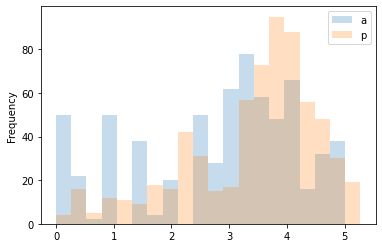

In [ ]:
SENT_TYPE = "ALL"
MODEL = "bert-base-uncased"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)


tokenizer = BertTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-5)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=3)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_loc = "/content/drive/My Drive/clinical-sts/models/tr-token-dnn-bert-{}-{:.4f}.pth".format(MODEL, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/tr-token-dnn-regression-{}-{:.4f}.pth".format(MODEL, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))



Training file:  /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Data already found at /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Epoch: 0 Train Loss:0.8440596594776272
Epoch: 0 Test Loss:0.6273091385163456

Epoch: 1 Train Loss:0.26533722610345106
Epoch: 1 Test Loss:0.7569067447659481

new test loss is greater; breaking
2.00    4.47          2.47     discussed diagnosis and treatment plan ; patient expressed understanding of the content .     |||    they verbalized agreement and understanding of the plan and contact information . 
0.00    3.17          3.17     i discussed with the patient the findings of the physical exam .     |||    i have confirmed with the organization system that i have counseled the patient . 
1.00    4.28          3.28     the patient is awake , alert , and oriented times three .     |||    patient is appreciative , understands a

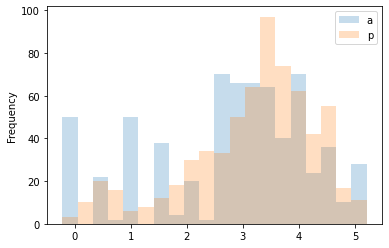

In [ ]:
SENT_TYPE = "ALL"
MODEL = "/content/drive/My Drive/clinical-sts/bio-bert/"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)


tokenizer = AutoTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-5)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=4)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_name = "bio-bert"
model_loc = "/content/drive/My Drive/clinical-sts/models/tr-token-dnn-bert-{}-{:.4f}.pth".format(model_name, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/tr-token-dnn-regression-{}-{:.4f}.pth".format(model_name, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))

Some weights of the model checkpoint at /content/drive/My Drive/clinical-sts/umls-bert/ were not used when initializing BertModel: ['bert.embeddings.tui_type_embeddings.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training file:  /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Data already found at /content/drive/My Drive/clinical-sts/data/translated_with_cui_embeddings/translated_train_cui_embeddings_ALL.tsv
Epoch: 0 Train Loss:0.8362864615378783
Epoch: 0 Test Loss:0.7384782659720226

Epoch: 1 Train Loss:0.2867968643697547
Epoch: 1 Test Loss:0.8436859686331577

new test loss is greater; breaking
2.00    4.61          2.61     discussed diagnosis and treatment plan ; patient expressed understanding of the content .     |||    they verbalized agreement and understanding of the plan and contact information . 
0.00    2.80          2.80     i discussed with the patient the findings of the physical exam .     |||    i have confirmed with the organization system that i have counseled the patient . 
1.50    3.55          2.05     the patient indicated they are not missing work , are not experiencing reduced productivity at work , are hav

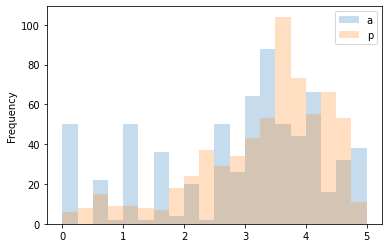

In [10]:
SENT_TYPE = "ALL"
MODEL = "/content/drive/My Drive/clinical-sts/umls-bert/"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)


tokenizer = AutoTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-5)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=4)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_name = "umls-bert"
model_loc = "/content/drive/My Drive/clinical-sts/models/tr-token-dnn-bert-{}-{:.4f}.pth".format(model_name, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/tr-token-dnn-regression-{}-{:.4f}.pth".format(model_name, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))